# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re


# Preprocessing Functions

In [143]:
def plot_laundering_fingerprints(file_path):
    """
    Parses a laundering pattern text file and generates a 'fingerprint' graph
    with time-relative alignment (T=0) and log scaling on the Y-axis.
    """
    # 1. Parsing Logic
    data = []
    current_pattern = None
    attempt_counter = 0 
    start_regex = re.compile(r"BEGIN LAUNDERING ATTEMPT - ([A-Z-]+)")
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
                
            start_match = start_regex.search(line)
            if start_match:
                current_pattern = start_match.group(1).strip()
                attempt_counter += 1 
                continue
            
            if "END LAUNDERING ATTEMPT" in line:
                current_pattern = None
                continue
            
            # Match timestamp format: YYYY/MM/DD
            if current_pattern and re.match(r'^\d{4}/\d{2}/\d{2}', line):
                parts = line.split(',')
                if len(parts) >= 11:
                    row_data = parts[:11] + [current_pattern, attempt_counter]
                    data.append(row_data)

    columns = ["Timestamp", "From_Bank", "From_Account", "To_Bank", "To_Account", 
               "Amount_Received", "Receiving_Currency", "Amount_Paid", "Payment_Currency", 
               "Payment_Format", "Is_Laundering", "Pattern_Type", "Attempt_ID"]
    
    df = pd.DataFrame(data, columns=columns)
    
    # 2. Data Cleaning
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Amount_Paid'] = pd.to_numeric(df['Amount_Paid'], errors='coerce')
    # Log scale requires values > 0
    df = df[df['Amount_Paid'] > 0]

    # 3. Visualization Setup
    plt.figure(figsize=(14, 8))
    unique_patterns = df['Pattern_Type'].unique()
    color_palette = cm.get_cmap('tab10', len(unique_patterns))
    pattern_to_color = {pat: color_palette(i) for i, pat in enumerate(unique_patterns)}

    # 4. Plot each discrete attempt relative to its own start time
    for attempt_id, group in df.groupby('Attempt_ID'):
        pattern_label = group['Pattern_Type'].iloc[0]
        group = group.sort_values('Timestamp')
        
        # Calculate T=0 (Relative Hours)
        start_time = group['Timestamp'].min()
        group['Relative_Hours'] = (group['Timestamp'] - start_time).dt.total_seconds() / 3600.0
        
        plt.plot(
            group['Relative_Hours'], 
            group['Amount_Paid'], 
            marker='o', 
            markersize=5,
            linestyle='-', 
            linewidth=1.2,
            alpha=0.6,
            color=pattern_to_color[pattern_label],
            label=pattern_label
        )

    # 5. Styling and Scaling
    plt.yscale('log')
    plt.title('Money Laundering "Pattern Fingerprints"\n(Aligned to T=0 | Logarithmic Magnitude)', fontsize=15, pad=20)
    plt.xlabel('Hours Since Start of Attempt', fontsize=12)
    plt.ylabel('Transaction Amount (Log Scale)', fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    # Consolidated Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Pattern Type", 
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [144]:

def plot_pattern_counts(file_path):
    """
    Parses a laundering pattern text file and generates a bar chart showing 
    the total number of discrete attempts for each pattern.
    """
    data = []
    attempt_counter = 0 
    start_regex = re.compile(r"BEGIN LAUNDERING ATTEMPT - ([A-Z-]+)")
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
                
            start_match = start_regex.search(line)
            if start_match:
                current_pattern = start_match.group(1).strip()
                attempt_counter += 1 
                # Store the attempt ID and pattern type
                data.append({'Pattern_Type': current_pattern, 'Attempt_ID': attempt_counter})
    
    df = pd.DataFrame(data)
    
    # Count unique attempts per pattern and sort for the bar chart
    counts = df.groupby('Pattern_Type')['Attempt_ID'].count().sort_values(ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title('Frequency of Discrete Laundering Patterns', fontsize=14)
    plt.xlabel('Pattern Type', fontsize=12)
    plt.ylabel('Number of Unique Attempts', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [2]:
def get_balanced_aml_data(df, target_col='Is Laundering', multiplier=2, random_state=20):

    "Fixes Class Imbalance by undersampling the majority class dynamically based on the number of positive cases."
    # 1. Identify the classes
    laundering_indices = df[df[target_col] == 1].index
    non_laundering_indices = df[df[target_col] == 0].index
    
    # 2. Calculate dynamic sample size
    n_pos = len(laundering_indices)
    n_neg_required = n_pos * multiplier
    
    print(f"Positive cases found: {n_pos}")
    print(f"Sampling {n_neg_required} negative cases (Ratio 1:{multiplier})")
    
    # 3. Randomly sample the negative indices
    sampled_neg_indices = pd.Series(non_laundering_indices).sample(
        n=n_neg_required, 
        random_state=random_state
    )
    
    # 4. Combine and shuffle
    combined_indices = laundering_indices.tolist() + sampled_neg_indices.tolist()
    balanced_df = df.loc[combined_indices].sample(frac=1, random_state=random_state)
    print("Sampling Done")
    
    return balanced_df.reset_index(drop=True)

In [3]:
def calculate_transaction_deltas(df, sender_col='Account', receiver_col='Account.1', time_col='Timestamp'):
    """
    Calculates the time elapsed since the last transaction for both 
    sender and receiver perspectives.
    """
    # 1. Create a copy and ensure datetime format
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Store the original index to restore order at the end
    original_index = df.index
    
    # 2. Calculate 'Time Since Last Send'
    print(f"Calculating deltas for Senders ({sender_col})...")
    df = df.sort_values(by=[sender_col, time_col])
    df['ts_delta_send'] = df.groupby(sender_col)[time_col].diff().dt.total_seconds()
    
    # 3. Calculate 'Time Since Last Receive'
    print(f"Calculating deltas for Receivers ({receiver_col})...")
    df = df.sort_values(by=[receiver_col, time_col])
    df['ts_delta_receive'] = df.groupby(receiver_col)[time_col].diff().dt.total_seconds()
    
    # 4. Fill NaNs with -1 (Cold Start Indicator)
    df[['ts_delta_send', 'ts_delta_receive']] = df[['ts_delta_send', 'ts_delta_receive']].fillna(-1)
    
    # 5. Restore original order
    return df.loc[original_index]



In [4]:
def calculate_transaction_frequency(df, groupby_col='Account', window_dict=None):
    """
    Calculates rolling transaction counts over multiple time windows.
    
    Parameters:
    df: pandas DataFrame
    groupby_col: The column to group by ('Account' for outgoing, 'Account.1' for incoming)
    window_dict: Dictionary of {label: window_size_str}
    """
    if window_dict is None:
        window_dict = {
            '1h': '1H', '6h': '6H', '24h': '1D', 
            '7d': '7D', '15d': '15D', '30d': '30D'
        }
        
    # 1. Prepare: Clean index and sort is mandatory for rolling time logic
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values(by=[groupby_col, 'Timestamp']).reset_index(drop=True)

    prefix = 'sent' if groupby_col == 'Account' else 'received'

    for label, window_size in window_dict.items():
        print(f"Calculating {label} frequency for {groupby_col}...")
        
        # 2. Rolling count calculation
        # We use the .values assignment to bypass MultiIndex alignment issues
        rolling_res = (
            df.groupby(groupby_col)
            .rolling(window_size, on='Timestamp')['Amount Paid']
            .count()
        )
        
        col_name = f'tx_count_{label}_{prefix}'
        df[col_name] = rolling_res.values
        
        # 3. Fill NaNs immediately for this column
        df[col_name] = df[col_name].fillna(1)

    return df



In [5]:

def apply_cyclical_features(df, datetime_col='Timestamp'):
    # Ensure it's datetime
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # 1. Extract raw components
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek # Monday=0, Sunday=6
    
    # 2. Sine/Cosine for Hour (Cycle of 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # 3. Sine/Cosine for Day of Week (Cycle of 7)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # We can now drop the raw 'hour' and 'day_of_week' columns 
    # to prevent the model from getting confused by redundant linear features
    return df



In [6]:
def calculate_off_hours_activity(df, threshold=0.8, amt_col='Amount Paid'):
    """
    Identifies transactions occurring during 'off-hours' using cyclical time features
    and calculates the dollar volume moved during those times.
    
    Parameters:
    df: DataFrame (must already have 'hour_cos' from cyclical encoding)
    threshold: float (0.8 corresponds roughly to 11 PM - 4 AM)
    amt_col: The column representing the transaction value
    """
    df = df.copy()
    
    if 'hour_cos' not in df.columns:
        print("Error: 'hour_cos' not found. Please run cyclical encoding first.")
        return df

    # 1. Create the Boolean Flag
    # High cosine values (near 1.0) represent the 'top' of the clock (Midnight)
    df['is_late_night'] = (df['hour_cos'] > threshold).astype(int)

    # 2. Calculate the specific dollar risk
    # This feature highlights accounts moving large sums while the world sleeps
    df['late_night_amt'] = df['is_late_night'] * df[amt_col]
    
    # 3. Aggregated Risk (Optional but powerful)
    # Total late night volume per account to date
    df['total_late_night_vol_per_acc'] = df.groupby('Account')['late_night_amt'].cumsum()

    return df

In [7]:
def calculate_network_topology(df, window='7D', suffix='7d'):
    # 1. Clean the index and ensure time sorting
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values(['Account', 'Timestamp'])

    # 2. FACTORIZE: Convert strings to unique integers
    # This solves the "could not convert string to float" error
    print("Factorizing Account IDs for processing...")
    df['acc_id_int'] = pd.factorize(df['Account'])[0]
    df['acc_1_id_int'] = pd.factorize(df['Account.1'])[0]

    # 3. Calculate Fan-Out
    print(f"Calculating Fan-Out ({window})...")
    # We apply the rolling unique count on the INTEGER version of the ID
    fan_out = (
        df.groupby('Account')
        .rolling(window, on='Timestamp')['acc_1_id_int']
        .apply(lambda x: len(np.unique(x)), raw=True) # raw=True is much faster
    )
    
    # 4. Calculate Fan-In
    # Re-sort for Fan-In grouping
    df = df.sort_values(['Account.1', 'Timestamp'])
    print(f"Calculating Fan-In ({window})...")
    fan_in = (
        df.groupby('Account.1')
        .rolling(window, on='Timestamp')['acc_id_int']
        .apply(lambda x: len(np.unique(x)), raw=True)
    )

    # 5. Assign back using the values
    df[f'fan_out_{suffix}'] = fan_out.values
    df[f'fan_in_{suffix}'] = fan_in.values
    
    # Cleanup and fill
    df = df.drop(columns=['acc_id_int', 'acc_1_id_int'])
    df[[f'fan_out_{suffix}', f'fan_in_{suffix}']] = df[[f'fan_out_{suffix}', f'fan_in_{suffix}']].fillna(1)
    
    return df


In [8]:
def calculate_amount_ratios(df, window='30D'):
    # 1. Ensure unique index and sorting
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values(['Account', 'Timestamp'])

    print(f"Calculating rolling average amount for {window}...")
    
    # 2. Calculate the rolling mean
    # We use closed='left' because we want the average of PRIOR transactions.
    # We don't want the current transaction to be part of the average it's being compared to.
    rolling_mean = (
        df.groupby('Account')
        .rolling(window, on='Timestamp')['Amount Paid']
        .mean()
    )
    # 3. Align and Calculate Ratio
    # We use .values to avoid the alignment errors we faced earlier
    df['rolling_avg_amount_30d'] = rolling_mean.values
    
    # 4. Calculate the Ratio (Current / Average)
    # We add a small epsilon (1e-6) to the denominator to avoid division by zero
    df['amt_spike_ratio'] = df['Amount Paid'] / (df['rolling_avg_amount_30d'] + 1e-6)

    # 5. Handle the "First Transaction" cases
    # If it's the first time we see an account, the ratio should be 1.0 (neutral)
    df['amt_spike_ratio'] = df['amt_spike_ratio'].fillna(1.0)

    # Calculate rolling standard deviation
    rolling_std = df.groupby('Account').rolling('30D', on='Timestamp')['Amount Paid'].std()
    df['amt_z_score'] = (df['Amount Paid'] - df['rolling_avg_amount_30d']) / (rolling_std.values + 1e-6)
    
    return df

In [9]:
def calculate_balance_wash(df, window_hours=2):
    # 1. Calculate total received by each account in the last X hours
    print("Calculating rolling receipts...")
    df = df.sort_values('Timestamp')
    
    # Received Amount (Account.1 is the receiver)
    received = (
        df.groupby('Account.1')
        .rolling(f'{window_hours}H', on='Timestamp')['Amount Received']
        .sum()
        .reset_index(level=0, drop=True)
    )
    
    # 2. Calculate total sent by each account in the last X hours
    print("Calculating rolling payments...")
    # Sent Amount (Account is the sender)
    sent = (
        df.groupby('Account')
        .rolling(f'{window_hours}H', on='Timestamp')['Amount Paid']
        .sum()
        .reset_index(level=0, drop=True)
    )
    
    # 3. Map back to main dataframe
    df['total_received_2h'] = received.values
    df['total_sent_2h'] = sent.values
    
    # 4. Calculate the "Wash" feature
    # A value close to 0 means the account is 'clearing' its balance
    df['net_flow_2h'] = df['total_received_2h'] - df['total_sent_2h']
    
    # 5. Create a Boolean flag for a 'Perfect Wash' (95% to 105% match)
    # We use a ratio to allow for small banking fees/skimming
    df['is_wash_detected'] = (
        (df['total_sent_2h'] > 0) & 
        (df['total_received_2h'] / (df['total_sent_2h'] + 1e-6)).between(0.95, 1.05)
    ).astype(int)
    
    return df

In [10]:
def calculate_discrepancy_features(df):
    """
    Identifies currency mismatches and significant differences 
    between paid and received amounts.
    """
    # 1. Currency Mismatch (FX Signal)
    df['is_fx_trade'] = (df['Receiving Currency'] != df['Payment Currency']).astype(int)
    
    # 2. Raw and Percentage Differences
    # amt_diff > 0 means the receiver got more (rare, potential error/bonus)
    # amt_diff < 0 means money 'disappeared' (fees, skimming, or laundering cuts)
    df['amt_diff'] = df['Amount Received'] - df['Amount Paid']
    df['amt_diff_pct'] = df['amt_diff'] / (df['Amount Paid'] + 1e-6)
    
    # 3. High Discrepancy Flag
    # Focuses on cases where currencies MATCH but the amounts DON'T.
    # A >1% gap in the same currency is a significant operational red flag.
    df['has_high_discrepancy'] = (
        (df['is_fx_trade'] == 0) & (df['amt_diff_pct'].abs() > 0.01)
    ).astype(int)
    
    return df

In [12]:
def prepare_categories(df):
    # Identify all columns that are currently strings/objects
    obj_cols = df.select_dtypes(include=['object']).columns
    
    print(f"Converting {len(obj_cols)} columns to category: {list(obj_cols)}")
    
    for col in obj_cols:
        df[col] = df[col].astype('category')
        
    return df

# Small Bank Dataset

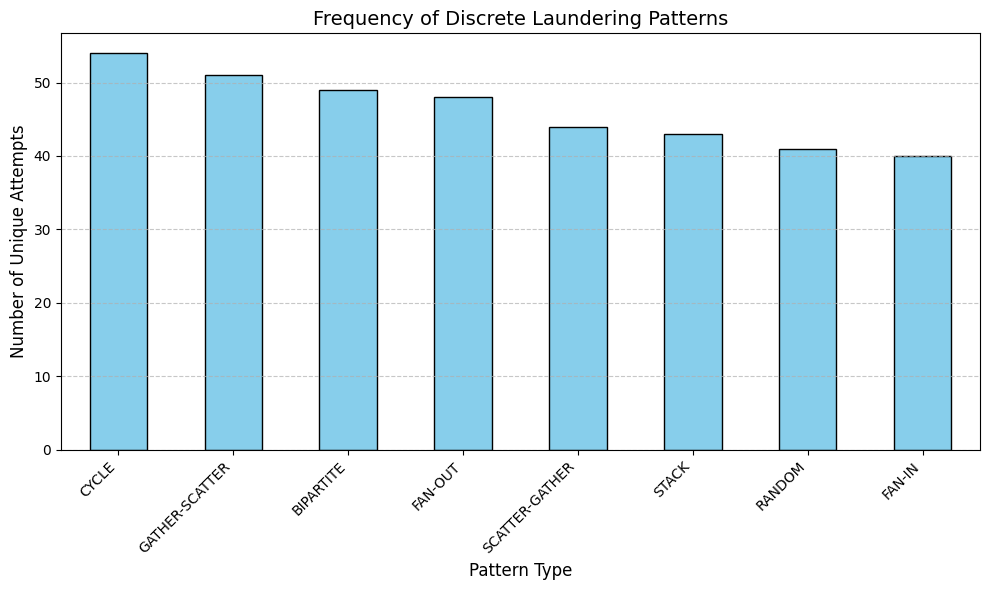

In [146]:
# Checking how many unique laundering patterns exist and their frequencies:
plot_pattern_counts('clean_data\small_bank_patterns.txt')

C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\3080972984.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(unique_patterns))


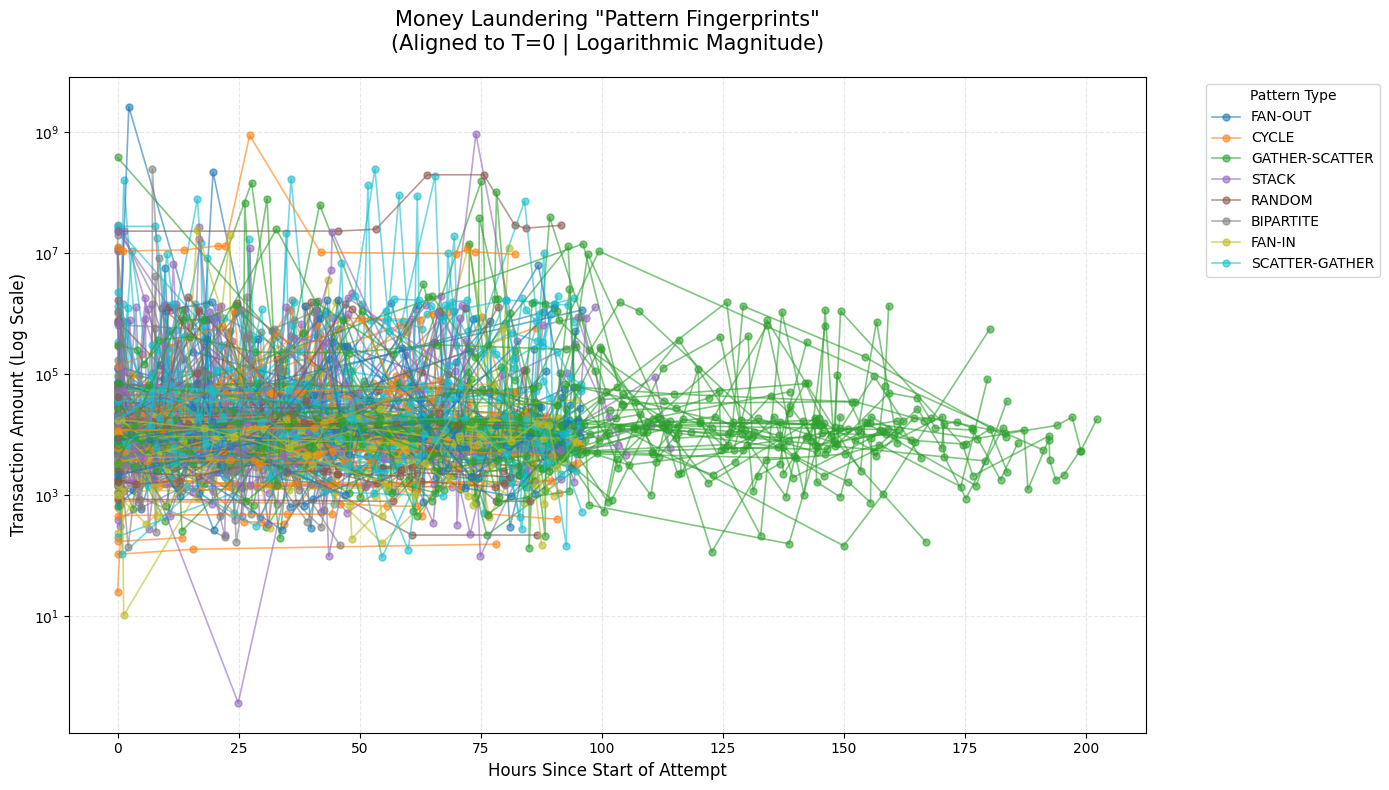

In [147]:
# checking how long the laundering activities last and their amounts:
plot_laundering_fingerprints('clean_data/small_bank_patterns.txt')

In [13]:
#loading the csv file and previewing the data
df_small= pd.read_csv("F:/Data_temp/HI-Small_Trans.csv")

In [14]:
df_small.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [15]:
df_small.info() #checking the filetypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [16]:
df_small.isnull().sum() #checking if there are null values

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [17]:
df_small.nunique()

Timestamp              15018
From Bank              30470
Account               496995
To Bank                15811
Account.1             420636
Amount Received       915161
Receiving Currency        15
Amount Paid           923873
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

In [18]:
df_small['Is Laundering'].value_counts() #chekking the distribution of target variable

Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

In [19]:
# Balancing the data with the defined undersampling function
df_small = get_balanced_aml_data(df_small)

Positive cases found: 5177
Sampling 10354 negative cases (Ratio 1:2)
Sampling Done


In [20]:
df_small

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/08 12:43,70,100428660,18324,809FFE610,68402.07,US Dollar,68402.07,US Dollar,Cash,1
1,2022/09/01 06:20,70,100428780,112989,8052436B0,1277.41,Rupee,1277.41,Rupee,Cheque,1
2,2022/09/07 21:26,25382,80C71F090,238387,812E5E180,3753.62,Euro,3753.62,Euro,Credit Card,0
3,2022/09/11 10:12,1467,8003E2010,1729,8088B1E00,791.72,US Dollar,791.72,US Dollar,ACH,1
4,2022/09/16 03:00,29404,8041A3440,143493,810128800,10307.27,Shekel,10307.27,Shekel,ACH,1
...,...,...,...,...,...,...,...,...,...,...,...
15526,2022/09/09 07:55,20,80B10A600,18107,8137C7AC0,6794.57,Yuan,6794.57,Yuan,Cheque,0
15527,2022/09/01 20:59,39439,8051541B0,39439,8051541B0,9486.65,US Dollar,9486.65,US Dollar,Reinvestment,0
15528,2022/09/05 10:24,24941,80950C850,125645,8098EC980,89.66,Canadian Dollar,89.66,Canadian Dollar,Cheque,0
15529,2022/09/09 17:48,214749,805DB7F20,3420,80AEBD9D0,9254.38,US Dollar,9254.38,US Dollar,ACH,1


#### That leaves us with approx 15k rows, Now we do feature engineering

In [21]:
# Caclulating transaction deltas with the defined function
df_small = calculate_transaction_deltas(df_small)

Calculating deltas for Senders (Account)...
Calculating deltas for Receivers (Account.1)...


In [22]:
# Calculating transaction frequency for Senders for predefined time frequencies with the function
df_small = calculate_transaction_frequency(df_small, groupby_col='Account')

Calculating 1h frequency for Account...


C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)
C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)


Calculating 6h frequency for Account...


C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)
C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)


Calculating 24h frequency for Account...
Calculating 7d frequency for Account...
Calculating 15d frequency for Account...
Calculating 30d frequency for Account...


In [23]:
#Calculating temporan patterns for accounts
df_small = apply_cyclical_features(df_small)

In [24]:
#Calculating late night/off-hours activity with the defined function
df_small = calculate_off_hours_activity(df_small)

In [25]:
#Calculating network topology features with the defined function
df_small = calculate_network_topology(df_small, window='7D', suffix='7d')

Factorizing Account IDs for processing...
Calculating Fan-Out (7D)...
Calculating Fan-In (7D)...


In [26]:
# calculating amount ratios with the defined function
df_small = calculate_amount_ratios(df_small)

Calculating rolling average amount for 30D...


In [27]:
# Discrepancy features calculation with the defined function
df_small = calculate_discrepancy_features(df_small)

In [28]:
df_small

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,total_late_night_vol_per_acc,fan_out_7d,fan_in_7d,rolling_avg_amount_30d,amt_spike_ratio,amt_z_score,is_fx_trade,amt_diff,amt_diff_pct,has_high_discrepancy
9133,2022-09-01 00:01:00,70,100428660,15980,80B39E7B0,7.929200e+02,US Dollar,7.929200e+02,US Dollar,Credit Card,...,792.92,1.0,1.0,7.929200e+02,1.000000,NaN,0,0.0,0.0,0
7911,2022-09-01 00:02:00,70,100428660,221691,8098BFEC0,7.658870e+03,US Dollar,7.658870e+03,US Dollar,Credit Card,...,8451.79,1.0,1.0,4.225895e+03,1.812366,0.707107,0,0.0,0.0,0
5082,2022-09-01 00:03:00,70,100428660,11474,805B716C0,2.902433e+04,US Dollar,2.902433e+04,US Dollar,Credit Card,...,13208901.65,2.0,1.0,1.249204e+04,2.323426,1.122873,0,0.0,0.0,0
10909,2022-09-01 00:03:00,70,100428660,113798,80DC756E0,1.317143e+07,US Dollar,1.317143e+07,US Dollar,Cheque,...,13179877.32,1.0,1.0,3.302225e+06,3.988651,1.499997,0,0.0,0.0,0
15194,2022-09-01 00:17:00,70,100428660,152980,8140702D0,6.892430e+03,US Dollar,6.892430e+03,US Dollar,Credit Card,...,13215794.08,1.0,1.0,2.643159e+06,0.002608,-0.447926,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15521,2022-09-01 21:50:00,256496,814931031,256496,814931031,1.483000e-03,Bitcoin,1.483000e-03,Bitcoin,Bitcoin,...,0.00,1.0,1.0,1.483000e-03,0.999326,NaN,0,0.0,0.0,0
15524,2022-09-09 07:02:00,54219,814959511,254565,814959ED1,2.705450e-01,Bitcoin,2.705450e-01,Bitcoin,Bitcoin,...,0.00,1.0,1.0,2.705450e-01,0.999996,NaN,0,0.0,0.0,0
15526,2022-09-05 03:46:00,112733,8149657F0,112733,8149657F0,8.622284e+04,Rupee,8.622284e+04,Rupee,Cheque,...,0.00,1.0,1.0,8.622284e+04,1.000000,NaN,0,0.0,0.0,0
13805,2022-09-07 19:02:00,249118,814965B00,222,811D80C30,3.492954e+04,Saudi Riyal,3.492954e+04,Saudi Riyal,ACH,...,0.00,1.0,14.0,3.492954e+04,1.000000,NaN,0,0.0,0.0,0


In [29]:
 
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15531 entries, 9133 to 99
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     15531 non-null  datetime64[ns]
 1   From Bank                     15531 non-null  int64         
 2   Account                       15531 non-null  object        
 3   To Bank                       15531 non-null  int64         
 4   Account.1                     15531 non-null  object        
 5   Amount Received               15531 non-null  float64       
 6   Receiving Currency            15531 non-null  object        
 7   Amount Paid                   15531 non-null  float64       
 8   Payment Currency              15531 non-null  object        
 9   Payment Format                15531 non-null  object        
 10  Is Laundering                 15531 non-null  int64         
 11  ts_delta_send                 155

##### Here, we need to change categories, and "to bank" and "from bank" are integers which also should be categories

In [30]:
df_small['To Bank'] = df_small['To Bank'].astype('category')
df_small['From Bank'] = df_small['From Bank'].astype('category')

In [31]:
# Usage
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15531 entries, 9133 to 99
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     15531 non-null  datetime64[ns]
 1   From Bank                     15531 non-null  category      
 2   Account                       15531 non-null  object        
 3   To Bank                       15531 non-null  category      
 4   Account.1                     15531 non-null  object        
 5   Amount Received               15531 non-null  float64       
 6   Receiving Currency            15531 non-null  object        
 7   Amount Paid                   15531 non-null  float64       
 8   Payment Currency              15531 non-null  object        
 9   Payment Format                15531 non-null  object        
 10  Is Laundering                 15531 non-null  int64         
 11  ts_delta_send                 155

In [32]:
df_small = prepare_categories(df_small)

Converting 5 columns to category: ['Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


In [33]:
df_small.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,total_late_night_vol_per_acc,fan_out_7d,fan_in_7d,rolling_avg_amount_30d,amt_spike_ratio,amt_z_score,is_fx_trade,amt_diff,amt_diff_pct,has_high_discrepancy
9133,2022-09-01 00:01:00,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,...,792.92,1.0,1.0,7.929200e+02,1.000000,NaN,0,0.0,0.0,0
7911,2022-09-01 00:02:00,70,100428660,221691,8098BFEC0,7658.87,US Dollar,7658.87,US Dollar,Credit Card,...,8451.79,1.0,1.0,4.225895e+03,1.812366,0.707107,0,0.0,0.0,0
5082,2022-09-01 00:03:00,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,...,13208901.65,2.0,1.0,1.249204e+04,2.323426,1.122873,0,0.0,0.0,0
10909,2022-09-01 00:03:00,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,...,13179877.32,1.0,1.0,3.302225e+06,3.988651,1.499997,0,0.0,0.0,0
15194,2022-09-01 00:17:00,70,100428660,152980,8140702D0,6892.43,US Dollar,6892.43,US Dollar,Credit Card,...,13215794.08,1.0,1.0,2.643159e+06,0.002608,-0.447926,0,0.0,0.0,0


In [34]:
df_small.isnull().sum() #checking if there are null values

Timestamp                           0
From Bank                           0
Account                             0
To Bank                             0
Account.1                           0
Amount Received                     0
Receiving Currency                  0
Amount Paid                         0
Payment Currency                    0
Payment Format                      0
Is Laundering                       0
ts_delta_send                       0
ts_delta_receive                    0
tx_count_1h_sent                    0
tx_count_6h_sent                    0
tx_count_24h_sent                   0
tx_count_7d_sent                    0
tx_count_15d_sent                   0
tx_count_30d_sent                   0
hour                                0
day_of_week                         0
hour_sin                            0
hour_cos                            0
day_sin                             0
day_cos                             0
is_late_night                       0
late_night_a

In [35]:
# "amt_z_score column seems to have some null values, we will fill them with 0 as it indicates first transaction for the account"
df_small['amt_z_score'].fillna(0, inplace=True)

C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\3796630188.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_small['amt_z_score'].fillna(0, inplace=True)


In [36]:
df_small.isnull().sum() #checking if there are remaining null values

Timestamp                       0
From Bank                       0
Account                         0
To Bank                         0
Account.1                       0
Amount Received                 0
Receiving Currency              0
Amount Paid                     0
Payment Currency                0
Payment Format                  0
Is Laundering                   0
ts_delta_send                   0
ts_delta_receive                0
tx_count_1h_sent                0
tx_count_6h_sent                0
tx_count_24h_sent               0
tx_count_7d_sent                0
tx_count_15d_sent               0
tx_count_30d_sent               0
hour                            0
day_of_week                     0
hour_sin                        0
hour_cos                        0
day_sin                         0
day_cos                         0
is_late_night                   0
late_night_amt                  0
total_late_night_vol_per_acc    0
fan_out_7d                      0
fan_in_7d     

In [37]:
#saving in parquet for scalability and also that categories and timestamps will be perfect!
df_small.to_parquet('clean_data/small_bank_HI_transactions_preprocessed.parquet', engine='fastparquet')

# Medium Bank Dataset

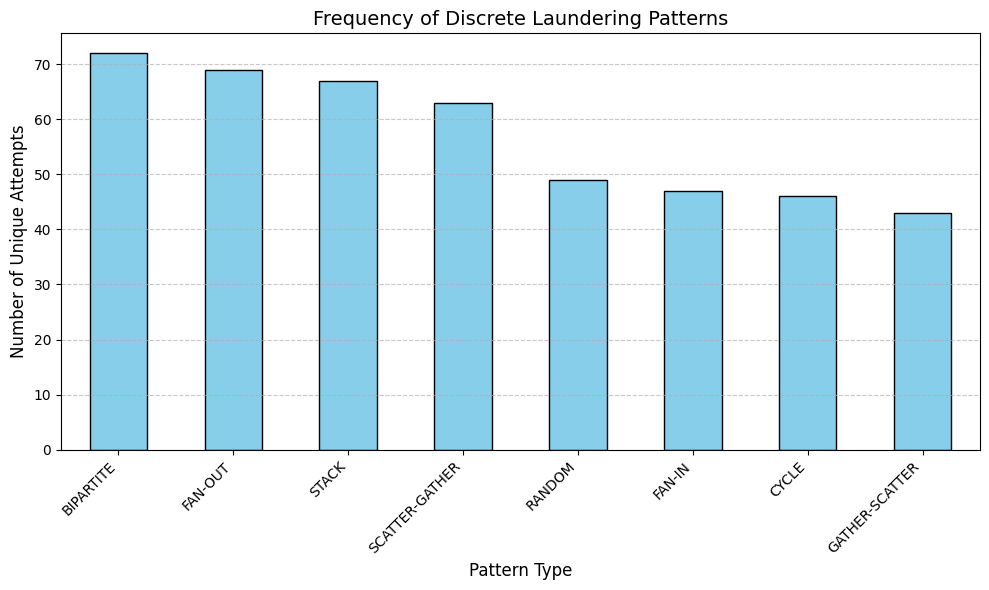

In [148]:
# Checking how many unique laundering patterns exist and their frequencies:
plot_pattern_counts('clean_data\medium_bank_patterns.txt')

C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\3080972984.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(unique_patterns))


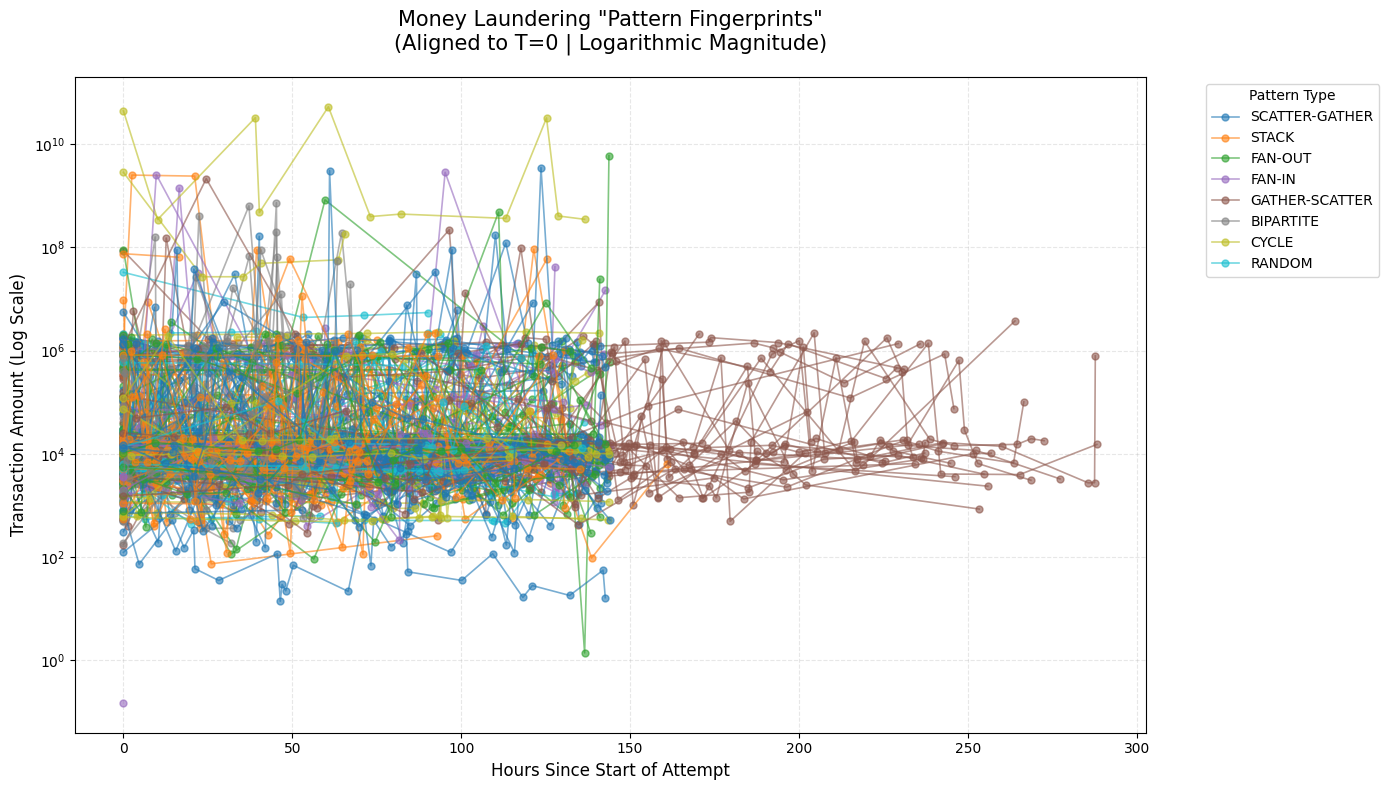

In [149]:
# checking how long the laundering activities last and their amounts:
plot_laundering_fingerprints('clean_data/medium_bank_patterns.txt')

In [14]:
#loading the csv file and previewing the data
df_medium= pd.read_csv("F:/Data_temp/LI-Medium_Trans.csv")

In [15]:
df_medium

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:15,20,800104D70,20,800104D70,8095.070000,US Dollar,8095.070000,US Dollar,Reinvestment,0
1,2022/09/01 00:18,3196,800107150,3196,800107150,7739.290000,US Dollar,7739.290000,US Dollar,Reinvestment,0
2,2022/09/01 00:23,1208,80010E430,1208,80010E430,2654.220000,US Dollar,2654.220000,US Dollar,Reinvestment,0
3,2022/09/01 00:19,3203,80010EA80,3203,80010EA80,13284.410000,US Dollar,13284.410000,US Dollar,Reinvestment,0
4,2022/09/01 00:27,20,800104D20,20,800104D20,9.720000,US Dollar,9.720000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
31251478,2022/09/16 23:46,1216195,84FDBD5D1,2213357,850556A01,0.992614,Bitcoin,0.992614,Bitcoin,Bitcoin,0
31251479,2022/09/16 23:43,1216195,84FDBD5D1,2213357,850556A01,1.962109,Bitcoin,1.962109,Bitcoin,Bitcoin,0
31251480,2022/09/16 23:31,1216195,84FDBD5D1,2213357,850556A01,0.149850,Bitcoin,0.149850,Bitcoin,Bitcoin,0
31251481,2022/09/16 23:57,1216195,84FDBD5D1,2213357,850556A01,0.025608,Bitcoin,0.025608,Bitcoin,Bitcoin,0


In [16]:
df_medium.info() #checking the filetypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31251483 entries, 0 to 31251482
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 2.6+ GB


In [17]:
df_medium.isnull().sum() #checking if there are null values

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [18]:
df_medium.nunique()

Timestamp               23761
From Bank              119616
Account               1969950
To Bank                 61523
Account.1             1653152
Amount Received       2765838
Receiving Currency         15
Amount Paid           2786576
Payment Currency           15
Payment Format              7
Is Laundering               2
dtype: int64

In [19]:
df_medium['Is Laundering'].value_counts() #chekking the distribution of target variable

Is Laundering
0    31235442
1       16041
Name: count, dtype: int64

In [20]:
# Balancing the data with the defined undersampling function
df_medium = get_balanced_aml_data(df_medium)

Positive cases found: 16041
Sampling 32082 negative cases (Ratio 1:2)
Sampling Done


In [21]:
# Caclulating transaction deltas with the defined function
df_medium = calculate_transaction_deltas(df_medium)

Calculating deltas for Senders (Account)...
Calculating deltas for Receivers (Account.1)...


In [22]:
# Calculating transaction frequency for Senders for predefined time frequencies with the function
df_medium = calculate_transaction_frequency(df_medium, groupby_col='Account')

Calculating 1h frequency for Account...


C:\Users\ahasa\AppData\Local\Temp\ipykernel_10324\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)
C:\Users\ahasa\AppData\Local\Temp\ipykernel_10324\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)


Calculating 6h frequency for Account...


C:\Users\ahasa\AppData\Local\Temp\ipykernel_10324\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)
C:\Users\ahasa\AppData\Local\Temp\ipykernel_10324\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)


Calculating 24h frequency for Account...
Calculating 7d frequency for Account...
Calculating 15d frequency for Account...
Calculating 30d frequency for Account...


In [23]:
df_medium

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,ts_delta_send,ts_delta_receive,tx_count_1h_sent,tx_count_6h_sent,tx_count_24h_sent,tx_count_7d_sent,tx_count_15d_sent,tx_count_30d_sent
0,2022-09-01 00:01:00,70,10042B660,269019,81E3733E0,8509.39,US Dollar,8509.39,US Dollar,Credit Card,0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-09-01 00:01:00,70,10042B660,14449,80426BB90,4302.05,US Dollar,4302.05,US Dollar,Cheque,1,0.0,-1.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2022-09-01 00:01:00,70,10042B660,1172306,84A44E7B0,719477.03,US Dollar,719477.03,US Dollar,Cheque,1,0.0,-1.0,3.0,3.0,3.0,3.0,3.0,3.0
3,2022-09-01 00:02:00,70,10042B660,37382,8125AFEE0,25076.27,US Dollar,25076.27,US Dollar,Cash,1,60.0,-1.0,4.0,4.0,4.0,4.0,4.0,4.0
4,2022-09-01 00:02:00,70,10042B660,137161,835AE7CC0,704.16,US Dollar,704.16,US Dollar,Cheque,0,0.0,-1.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48118,2022-09-14 16:13:00,2152989,850597170,31603,8505972B0,3689.10,Euro,3689.10,Euro,ACH,1,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
48119,2022-09-12 16:35:00,1182931,8505A0DC0,229187,8505A0F00,1107.41,Euro,1107.41,Euro,ACH,1,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
48120,2022-09-01 21:15:00,130012,8505A2200,130012,8505A2200,21.03,Euro,21.03,Euro,Reinvestment,0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
48121,2022-09-01 00:26:00,255963,8505BE1C0,255963,8505BE1C0,47281.19,US Dollar,47281.19,US Dollar,Reinvestment,0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:

#Calculating temporan patterns for accounts
df_medium = apply_cyclical_features(df_medium)

In [25]:
#Calculating late night/off-hours activity with the defined function
df_medium = calculate_off_hours_activity(df_medium)

In [26]:
#Calculating network topology features with the defined function
df_medium = calculate_network_topology(df_medium, window='7D', suffix='7d')

Factorizing Account IDs for processing...
Calculating Fan-Out (7D)...
Calculating Fan-In (7D)...


In [27]:
# calculating amount ratios with the defined function
df_medium = calculate_amount_ratios(df_medium)

Calculating rolling average amount for 30D...


In [28]:
# Discrepancy features calculation with the defined function
df_medium = calculate_discrepancy_features(df_medium)

In [29]:
df_medium

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,total_late_night_vol_per_acc,fan_out_7d,fan_in_7d,rolling_avg_amount_30d,amt_spike_ratio,amt_z_score,is_fx_trade,amt_diff,amt_diff_pct,has_high_discrepancy
3441,2022-09-01 00:01:00,70,10042B660,14449,80426BB90,4302.05,US Dollar,4302.05,US Dollar,Cheque,...,12811.44,664.0,1.0,4302.050000,1.000000,NaN,0,0.0,0.0,0
20267,2022-09-01 00:01:00,70,10042B660,269019,81E3733E0,8509.39,US Dollar,8509.39,US Dollar,Credit Card,...,8509.39,1.0,1.0,6405.720000,1.328405,0.707107,0,0.0,0.0,0
44835,2022-09-01 00:01:00,70,10042B660,1172306,84A44E7B0,719477.03,US Dollar,719477.03,US Dollar,Cheque,...,732288.47,1.0,1.0,244096.156667,2.947515,1.154685,0,0.0,0.0,0
13111,2022-09-01 00:02:00,70,10042B660,37382,8125AFEE0,25076.27,US Dollar,25076.27,US Dollar,Cash,...,757364.74,1.0,1.0,189341.185000,0.132440,-0.464632,0,0.0,0.0,0
33620,2022-09-01 00:02:00,70,10042B660,137161,835AE7CC0,704.16,US Dollar,704.16,US Dollar,Cheque,...,758068.90,1.0,1.0,151613.780000,0.004644,-0.475183,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48105,2022-09-14 16:13:00,2152989,850597170,31603,8505972B0,3689.10,Euro,3689.10,Euro,ACH,...,0.00,1.0,1.0,3689.100000,1.000000,NaN,0,0.0,0.0,0
48109,2022-09-12 16:35:00,1182931,8505A0DC0,229187,8505A0F00,1107.41,Euro,1107.41,Euro,ACH,...,0.00,1.0,1.0,1107.410000,1.000000,NaN,0,0.0,0.0,0
48110,2022-09-01 21:15:00,130012,8505A2200,130012,8505A2200,21.03,Euro,21.03,Euro,Reinvestment,...,0.00,1.0,1.0,21.030000,1.000000,NaN,0,0.0,0.0,0
48114,2022-09-01 00:26:00,255963,8505BE1C0,255963,8505BE1C0,47281.19,US Dollar,47281.19,US Dollar,Reinvestment,...,47281.19,1.0,1.0,47281.190000,1.000000,NaN,0,0.0,0.0,0


In [30]:
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48123 entries, 3441 to 48122
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     48123 non-null  datetime64[ns]
 1   From Bank                     48123 non-null  int64         
 2   Account                       48123 non-null  object        
 3   To Bank                       48123 non-null  int64         
 4   Account.1                     48123 non-null  object        
 5   Amount Received               48123 non-null  float64       
 6   Receiving Currency            48123 non-null  object        
 7   Amount Paid                   48123 non-null  float64       
 8   Payment Currency              48123 non-null  object        
 9   Payment Format                48123 non-null  object        
 10  Is Laundering                 48123 non-null  int64         
 11  ts_delta_send                 

In [31]:
df_medium['To Bank'] = df_medium['To Bank'].astype('category')
df_medium['From Bank'] = df_medium['From Bank'].astype('category')

In [12]:
# "amt_z_score column seems to have some null values, we will fill them with 0 as it indicates first transaction for the account"
df_medium['amt_z_score'].fillna(0, inplace=True)

C:\Users\ahasa\AppData\Local\Temp\ipykernel_21060\599772806.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_medium['amt_z_score'].fillna(0, inplace=True)


In [32]:
#saving in parquet for scalability and also that categories and timestamps will be perfect!
df_medium = prepare_categories(df_medium)
df_medium.to_parquet('clean_data/medium_bank_LI_transactions_preprocessed.parquet', engine='fastparquet')

Converting 5 columns to category: ['Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


# Large Bank Dataset

##### Workaround: Since this data size is too large to fit into local CPU RAM, we will split it in chunks and load the positive cases first, then we will sample with negative cases 

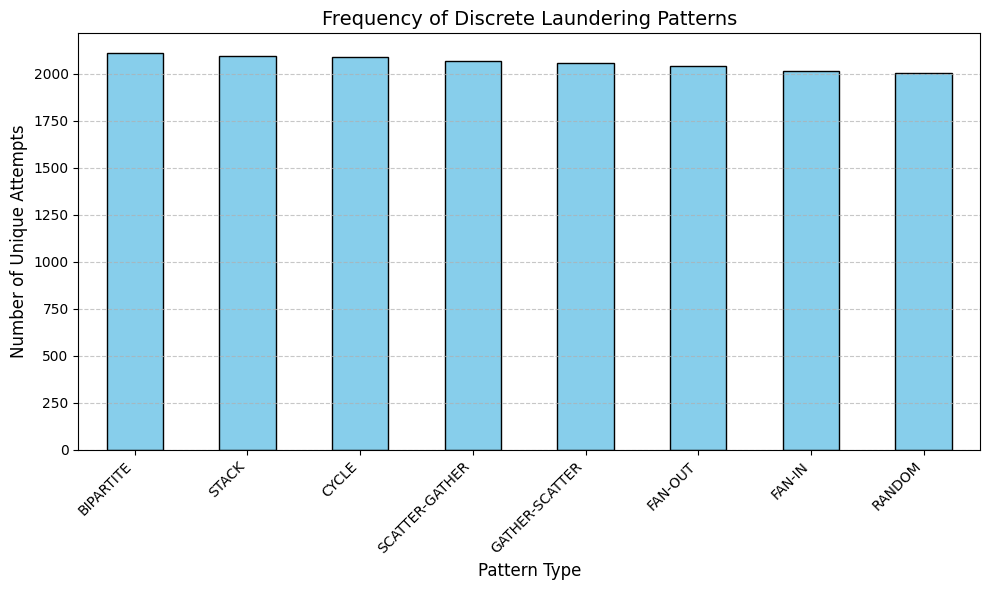

In [150]:
# Checking how many unique laundering patterns exist and their frequencies:
plot_pattern_counts('clean_data\large_bank_patterns.txt')

C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\3080972984.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(unique_patterns))


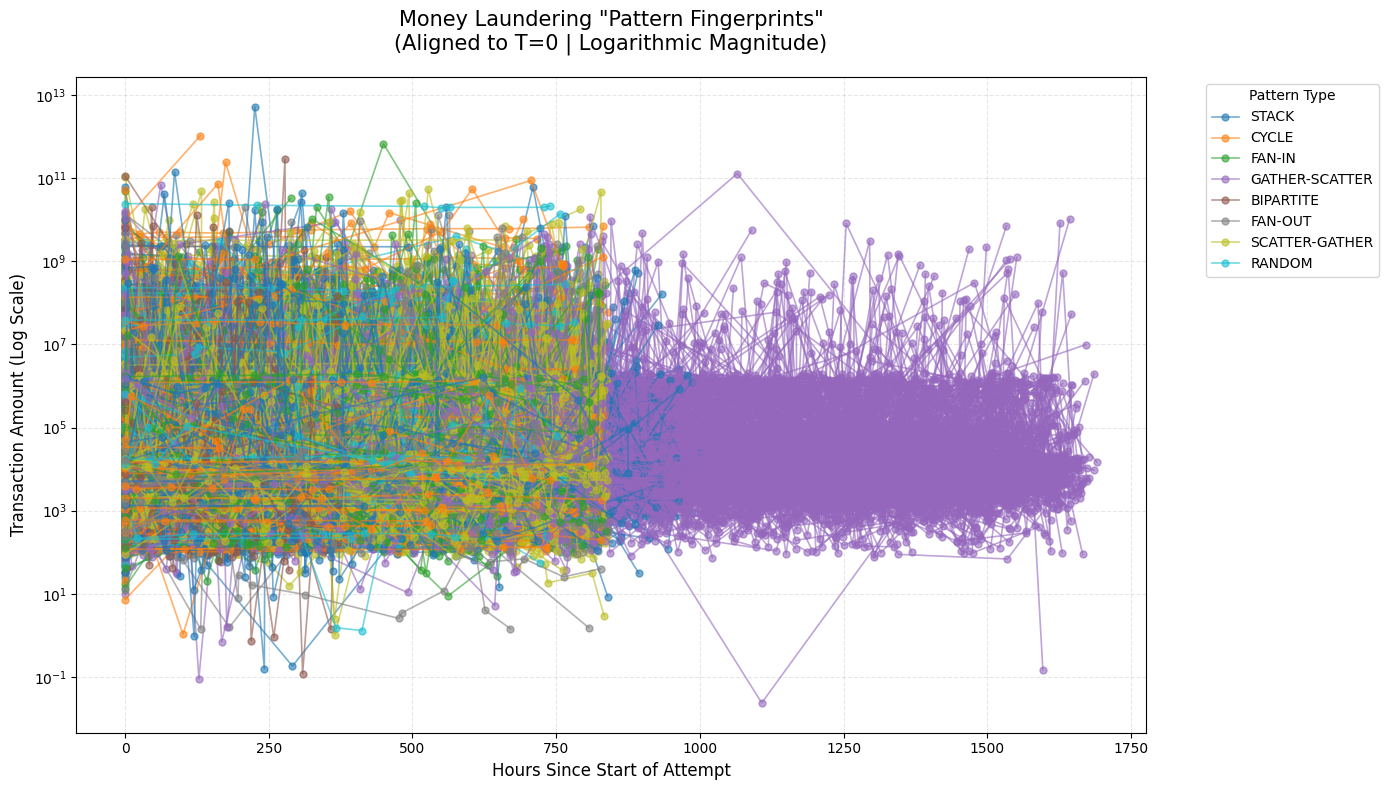

In [151]:
# checking how long the laundering activities last and their amounts:
plot_laundering_fingerprints('clean_data/large_bank_patterns.txt')

In [107]:
#Loading large file in chunks for preprocessing

dtypes = {
    'From Bank': 'int64',
    'Account': 'str',
    'To Bank': 'int64',
    'Account.1': 'str',
    'Amount Received': 'float64',
    'Receiving Currency': 'str',
    'Amount Paid': 'float64',
    'Payment Currency': 'str',
    'Payment Format': 'str',
    'Is Laundering': 'int64'
}

chunks = pd.read_csv(
    "F:/Data_temp/HI-Large_Trans.csv",
    dtype=dtypes,
    parse_dates=["Timestamp"],
    chunksize=500_000,
    low_memory=False
)

#### We need to avoid sampling bias, therefore we will pick negative cases in between time windows for positive cases start date and end date

In [83]:
dfs_pos = []

for chunk in chunks:
    pos = chunk[chunk["Is Laundering"] == 1]
    if not pos.empty:
        dfs_pos.append(pos)

df_pos = pd.concat(dfs_pos, ignore_index=True)
N_pos = len(df_pos)

print("Positive cases:", N_pos)


Positive cases: 225546


In [85]:
dfs_neg = []
remaining = 2 * N_pos

chunks = pd.read_csv(
    "F:/Data_temp/HI-Large_Trans.csv",
    dtype=dtypes,
    parse_dates=["Timestamp"],
    chunksize=500_000,
    low_memory=False
)

for chunk in chunks:
    neg = chunk[
        (chunk["Is Laundering"] == 0) &
        (chunk["Timestamp"] >= pos_start) &
        (chunk["Timestamp"] <= pos_end)
    ]

    if neg.empty:
        continue

    if len(neg) <= remaining:
        dfs_neg.append(neg)
        remaining -= len(neg)
    else:
        dfs_neg.append(neg.sample(remaining, random_state=11))
        break


In [ ]:
df_large = pd.concat([dfs_pos, dfs_neg], ignore_index=True)
df_large = df_large.sort_values("Timestamp").reset_index(drop=True)


In [108]:
dtypes = {
    'From Bank': 'int64',
    'Account': 'str',
    'To Bank': 'int64',
    'Account.1': 'str',
    'Amount Received': 'float64',
    'Receiving Currency': 'str',
    'Amount Paid': 'float64',
    'Payment Currency': 'str',
    'Payment Format': 'str',
    'Is Laundering': 'int64'
}

file_path = "F:/Data_temp/HI-Large_Trans.csv"

# --- PASS 1: Get Positives and Stats ---
chunks = pd.read_csv(
    file_path,
    dtype=dtypes,
    parse_dates=["Timestamp"],
    chunksize=500_000,
    low_memory=False
)

dfs_pos = []
total_rows_approx = 0

for chunk in chunks:
    total_rows_approx += len(chunk)
    pos = chunk[chunk["Is Laundering"] == 1]
    if not pos.empty:
        dfs_pos.append(pos)

df_pos = pd.concat(dfs_pos, ignore_index=True)
N_pos = len(df_pos)

# 1. Get the time window of the positive cases
min_pos_date = df_pos['Timestamp'].min()
max_pos_date = df_pos['Timestamp'].max()

print(f"Positives: {N_pos}")
print(f"Positive Time Window: {min_pos_date} to {max_pos_date}")

# --- PASS 2: Sample Negatives Uniformly ---

# 2. Calculate a sampling rate
# We want roughly 2x positives. 
# We add a safety factor (e.g., 5x) to ensure we get enough after date filtering, 
# then we downsample exactly later.
target_neg = 2 * N_pos
safety_factor = 4.0 
sampling_frac = (target_neg / total_rows_approx) * safety_factor

print(f"Sampling {sampling_frac:.5f} of negatives from each chunk...")

chunks = pd.read_csv(
    file_path,
    dtype=dtypes,
    parse_dates=["Timestamp"],
    chunksize=500_000,
    low_memory=False
)

dfs_neg = []

for chunk in chunks:
    # A. Filter for class
    neg = chunk[chunk["Is Laundering"] == 0]
    
    # B. Filter for Time Window (Strict Containment)
    # This ensures negatives are only from the period where fraud exists
    mask_window = (neg['Timestamp'] >= min_pos_date) & (neg['Timestamp'] <= max_pos_date)
    neg = neg[mask_window]

    if neg.empty:
        continue

    # C. Sample a fraction of this chunk
    # This ensures we get candidates from the Start, Middle, and End of the file
    neg_sampled = neg.sample(frac=sampling_frac, random_state=11)
    
    dfs_neg.append(neg_sampled)

# Concatenate all candidate negatives
df_neg_candidates = pd.concat(dfs_neg, ignore_index=True)

# --- Finalize ---

# If we grabbed too many (due to safety factor), sample down to exact number
if len(df_neg_candidates) > target_neg:
    df_neg = df_neg_candidates.sample(n=target_neg, random_state=11)
else:
    print(f"Warning: Only found {len(df_neg_candidates)} valid negatives in time window.")
    df_neg = df_neg_candidates

print(f"Selected Negatives: {len(df_neg)}")

# Create final dataset
df_large = pd.concat([df_pos, df_neg], ignore_index=True)

# Shuffle strictly before splitting (optional, but good practice before time-sort)
df_large = df_large.sample(frac=1, random_state=11).reset_index(drop=True)

# Sort by time for your Temporal Split
df_large = df_large.sort_values('Timestamp').reset_index(drop=True)

print("Dataset ready for temporal split.")

Positives: 225546
Positive Time Window: 2022-08-01 00:01:00 to 2023-01-12 16:49:00
Sampling 0.01004 of negatives from each chunk...
Selected Negatives: 451092
Dataset ready for temporal split.


In [109]:
df_large

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-08-01 00:01:00,155799,814A68530,155799,814A68530,2053.82,Yen,2053.82,Yen,Reinvestment,0
1,2022-08-01 00:01:00,140373,849BE0300,140373,849BE0300,2878.19,US Dollar,2878.19,US Dollar,Reinvestment,0
2,2022-08-01 00:01:00,16315,803466CF0,35210,81C608060,3165.64,US Dollar,3165.64,US Dollar,Credit Card,0
3,2022-08-01 00:01:00,1100175,848A5D670,1100175,848A5D670,8.95,US Dollar,8.95,US Dollar,Reinvestment,0
4,2022-08-01 00:01:00,6697,804EEAAB0,25935,8056E8A70,65870.49,US Dollar,65870.49,US Dollar,Cheque,0
...,...,...,...,...,...,...,...,...,...,...,...
676633,2023-01-11 10:57:00,1488,8026183B0,7818,803F9F940,16474.88,US Dollar,16474.88,US Dollar,ACH,1
676634,2023-01-12 07:27:00,159278,8162FCF80,111632,804F0CC10,11993.05,US Dollar,11993.05,US Dollar,ACH,1
676635,2023-01-12 09:09:00,37048,80DCEF130,115813,813CC4700,6858.20,US Dollar,6858.20,US Dollar,ACH,1
676636,2023-01-12 13:33:00,126614,82E6C0F40,110,82E6C08C0,21021.52,Australian Dollar,21021.52,Australian Dollar,ACH,1


In [110]:
df_large['Is Laundering'].value_counts()

Is Laundering
0    451092
1    225546
Name: count, dtype: int64

In [111]:
df_large.isnull().sum() #checking if there are null values

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [112]:
df_large.nunique() #For reporting purposes

Timestamp             153873
From Bank              17152
Account               362044
To Bank                 7663
Account.1             452483
Amount Received       465224
Receiving Currency        15
Amount Paid           466040
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

In [113]:
# Caclulating transaction deltas with the defined function
df_large = calculate_transaction_deltas(df_large)

Calculating deltas for Senders (Account)...
Calculating deltas for Receivers (Account.1)...


In [114]:
# Calculating transaction frequency for Senders for predefined time frequencies with the function
df_large = calculate_transaction_frequency(df_large, groupby_col='Account')

Calculating 1h frequency for Account...


C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)
C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)


Calculating 6h frequency for Account...


C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)
C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\1400279813.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(groupby_col)


Calculating 24h frequency for Account...
Calculating 7d frequency for Account...
Calculating 15d frequency for Account...
Calculating 30d frequency for Account...


In [115]:
#Calculating temporan patterns for accounts
df_large = apply_cyclical_features(df_large)

In [116]:
#Calculating late night/off-hours activity with the defined function
df_large = calculate_off_hours_activity(df_large)

In [117]:
#Calculating network topology features with the defined function
df_large = calculate_network_topology(df_large, window='7D', suffix='7d')

Factorizing Account IDs for processing...
Calculating Fan-Out (7D)...
Calculating Fan-In (7D)...


In [118]:
# calculating amount ratios with the defined function
df_large = calculate_amount_ratios(df_large)

Calculating rolling average amount for 30D...


In [119]:
# Discrepancy features calculation with the defined function
df_large = calculate_discrepancy_features(df_large)

In [120]:
df_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 676638 entries, 279535 to 50368
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Timestamp                     676638 non-null  datetime64[ns]
 1   From Bank                     676638 non-null  int64         
 2   Account                       676638 non-null  object        
 3   To Bank                       676638 non-null  int64         
 4   Account.1                     676638 non-null  object        
 5   Amount Received               676638 non-null  float64       
 6   Receiving Currency            676638 non-null  object        
 7   Amount Paid                   676638 non-null  float64       
 8   Payment Currency              676638 non-null  object        
 9   Payment Format                676638 non-null  object        
 10  Is Laundering                 676638 non-null  int64         
 11  ts_delta_send 

In [121]:
df_large['To Bank'] = df_large['To Bank'].astype('category')
df_large['From Bank'] = df_large['From Bank'].astype('category')

In [122]:
df_large = prepare_categories(df_large)

Converting 5 columns to category: ['Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


In [123]:
# "amt_z_score column seems to have some null values, we will fill them with 0 as it indicates first transaction for the account"
df_large['amt_z_score'].fillna(0, inplace=True)

C:\Users\ahasa\AppData\Local\Temp\ipykernel_15264\2146364133.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_large['amt_z_score'].fillna(0, inplace=True)


In [124]:
df_large.isnull().sum() #checking if there are null values

Timestamp                       0
From Bank                       0
Account                         0
To Bank                         0
Account.1                       0
Amount Received                 0
Receiving Currency              0
Amount Paid                     0
Payment Currency                0
Payment Format                  0
Is Laundering                   0
ts_delta_send                   0
ts_delta_receive                0
tx_count_1h_sent                0
tx_count_6h_sent                0
tx_count_24h_sent               0
tx_count_7d_sent                0
tx_count_15d_sent               0
tx_count_30d_sent               0
hour                            0
day_of_week                     0
hour_sin                        0
hour_cos                        0
day_sin                         0
day_cos                         0
is_late_night                   0
late_night_amt                  0
total_late_night_vol_per_acc    0
fan_out_7d                      0
fan_in_7d     

In [126]:
# Sort by time for your Temporal Split
df_large = df_large.sort_values('Timestamp').reset_index(drop=True)

In [127]:
df_large

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,total_late_night_vol_per_acc,fan_out_7d,fan_in_7d,rolling_avg_amount_30d,amt_spike_ratio,amt_z_score,is_fx_trade,amt_diff,amt_diff_pct,has_high_discrepancy
0,2022-08-01 00:01:00,70,100428660,56386,8196AFD50,22641.60,US Dollar,22641.60,US Dollar,Credit Card,...,428880.54,1.0,1.0,2.264160e+04,1.000000,0.000000,0,0.0,0.0,0
1,2022-08-01 00:01:00,14027,8021A1BA0,14027,8021A1BA0,1438651.73,US Dollar,1438651.73,US Dollar,Reinvestment,...,1438651.73,341.0,1.0,1.438652e+06,1.000000,0.000000,0,0.0,0.0,0
2,2022-08-01 00:01:00,1187327,8479CE2F0,1187327,8479CE2F0,21.53,Shekel,21.53,Shekel,Reinvestment,...,21.53,1.0,1.0,2.153000e+01,1.000000,0.000000,0,0.0,0.0,0
3,2022-08-01 00:01:00,156591,8399CC250,156591,8399CC250,38.35,Brazil Real,38.35,Brazil Real,Reinvestment,...,38.35,1.0,1.0,3.835000e+01,1.000000,0.000000,0,0.0,0.0,0
4,2022-08-01 00:01:00,120376,80B630EF0,120376,80B630EF0,5912.09,Euro,5912.09,Euro,Reinvestment,...,5912.09,1.0,1.0,5.912090e+03,1.000000,0.000000,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676633,2023-01-11 10:57:00,1488,8026183B0,7818,803F9F940,16474.88,US Dollar,16474.88,US Dollar,ACH,...,5542.63,98.0,1.0,8.715390e+03,1.890320,1.396407,0,0.0,0.0,0
676634,2023-01-12 07:27:00,159278,8162FCF80,111632,804F0CC10,11993.05,US Dollar,11993.05,US Dollar,ACH,...,337131.46,1.0,1.0,1.300349e+04,0.922295,-0.062224,0,0.0,0.0,0
676635,2023-01-12 09:09:00,37048,80DCEF130,115813,813CC4700,6858.20,US Dollar,6858.20,US Dollar,ACH,...,121058.64,1.0,1.0,2.604948e+08,0.000026,-0.288963,0,0.0,0.0,0
676636,2023-01-12 13:33:00,126614,82E6C0F40,110,82E6C08C0,21021.52,Australian Dollar,21021.52,Australian Dollar,ACH,...,5494768.93,1.0,1.0,1.768055e+04,1.188963,0.405959,0,0.0,0.0,0


In [128]:
#saving in parquet for scalability and also that categories and timestamps will be perfect!
df_large.to_parquet('clean_data/large_bank_HI_transactions_preprocessed.parquet', engine='fastparquet')

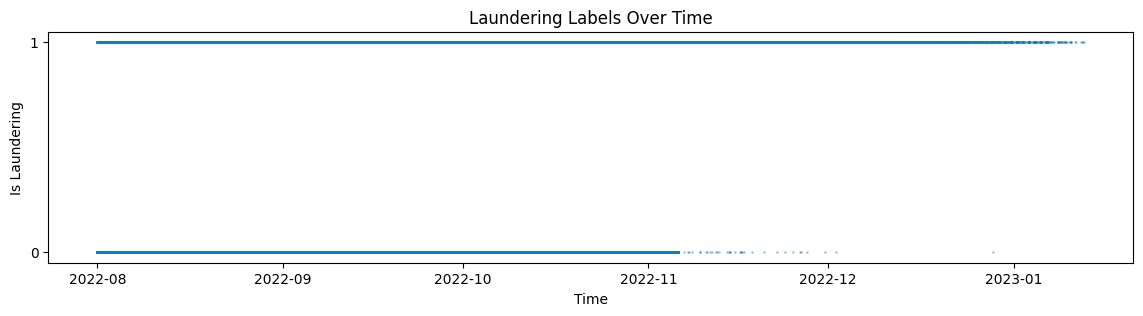

In [129]:
#Checking Laundering labels over time
plt.figure(figsize=(14, 3))
plt.scatter(
    df_large["Timestamp"],
    df_large["Is Laundering"],
    s=1,
    alpha=0.3
)
plt.yticks([0, 1])
plt.xlabel("Time")
plt.ylabel("Is Laundering")
plt.title("Laundering Labels Over Time")
plt.show()
